In [49]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np

In [50]:
# Load MNIST (28x28 grayscale images of digits 0–9)
mnist = fetch_openml('mnist_784', version=1)
X = mnist["data"] / 255.0                      # Normalize pixel values to 0–1
y = mnist["target"].astype(int)               # Convert labels from str to int

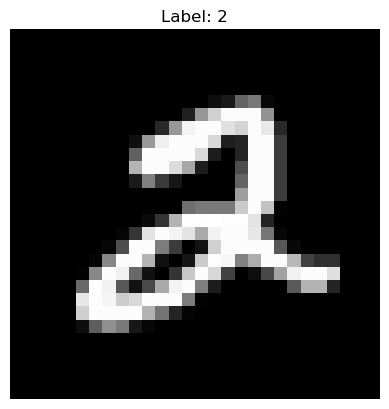

In [87]:
import matplotlib.pyplot as plt
index = 5

# Reshape the 784-length vector to 28x28
image = X.iloc[index].values.reshape(28, 28)

# Plot it
plt.imshow(image, cmap='gray')
plt.title(f"Label: {y[index]}")
plt.axis('off')
plt.show()


one hot encoding 

y_encoded will have shape (70000, 10) suitable for softmax + cross-entropy loss.
This is needed for training a multi-class neural network.

In [88]:
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y] # creates a 10×10 identity matrix.

y_encoded = one_hot_encode(y)

In [89]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Train shape: (56000, 784) (56000, 10)
Test shape: (14000, 784) (14000, 10)


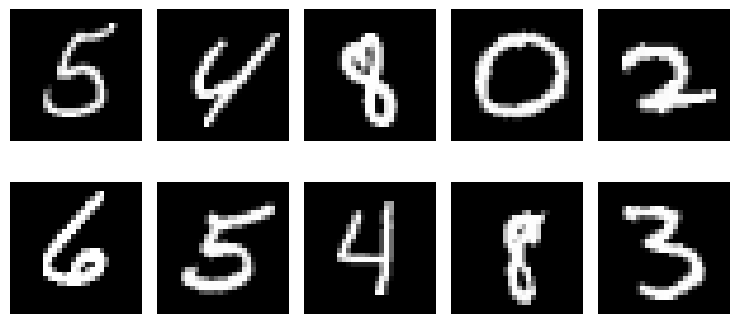

In [110]:
# Train-test split (80/20)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42 #ensures reproducibility of the split.
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
show_images(X_train)

In [111]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


Define Architecture and Initialize Parameters

creating a 3-layer neural network with 784 input features, two hidden layers of sizes 128 and 64, and an output layer of 10 classes.
The weights W1, W2, and W3 are randomly initialized with small values to break symmetry.
Biases b1, b2, and b3 are initialized to zeros for each corresponding layer.

In [ ]:
# Input: 784 pixels, Hidden1: 128 units,hidden2:64 Output: 10 classes
input_size = 784
hidden_size = 128
output_size = 10
# Initialize weights and biases
W1 = np.random.randn(784, 128) * 0.01
b1 = np.zeros((1, 128))

W2 = np.random.randn(128, 64) * 0.01
b2 = np.zeros((1, 64))

W3 = np.random.randn(64, 10) * 0.01
b3 = np.zeros((1, 10))

print("W1 shape:", W1.shape)
print("W2 shape:", W2.shape)
print("W3 shape:", W3.shape)

W1 shape: (784, 128)
W2 shape: (128, 64)
W3 shape: (64, 10)


Activation Functions

ReLU is used in hidden layers to introduce non-linearity by setting all negative values to zero.
This helps the network learn complex patterns without vanishing gradients.

Softmax is used in the output layer to convert raw scores into probabilities.
It ensures all output values lie between 0 and 1 and sum to 1 across classes.
np.max subtraction is a stability trick to avoid numerical overflow during exponentiation.
The final result is a probability distribution over 10 output classes.

In [206]:
# ReLU for hidden layer
def relu(x):
    return np.maximum(0, x)

# Softmax for output layer
def softmax(x):
    x = np.array(x)  # Ensure it's a NumPy array
    x -= np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def dropout(A, rate=0.5):
    mask = (np.random.rand(*A.shape) > rate).astype(np.float32)
    return A * mask / (1 - rate)



Forward Pass Function

forward function performs a complete pass through the network computing z and applying activation functions 
return just A3 from forward() because it represents the final predictions.

In [207]:
# Run forward pass on any batch
def forward(X):
    global Z1, A1, Z2, A2 ,Z3,A3 # Save for later use in backprop
    Z1 = X @ W1 + b1       
    A1 = relu(Z1)          
    Z2 = A1 @ W2 + b2      
    A2 = relu(Z2)       
    Z3 = A2 @ W3 + b3
    A3 = softmax(Z3)
    return A3


Test Forward Pass on a Batch

testing forward pass using a mini-batch of 32 training samples.
Calling forward(batch_X) returns preds, which should be A3, i.e. output probabilities.
Each prediction should be a vector of 10 values (for 10 classes).
preds.shape should be (32, 10) and each row should sum to ~1 due to softmax.
Printing the first prediction and its sum confirms the output format and normalization.

In [208]:
# Try a mini-batch of 32 images
batch_X = X_train[:32]
batch_y = y_train[:32]

preds = forward(batch_X)

print("Prediction shape:", preds.shape)
print("First prediction:", preds[0])
print("Sum of probs (should be ~1):", np.sum(preds[0]))


Prediction shape: (32, 10)
First prediction: [3.98408609e-14 3.23019940e-12 6.29870117e-19 3.82090341e-08
 7.02138742e-18 9.99999960e-01 1.10007765e-09 1.03903862e-23
 3.05292164e-10 7.07516965e-11]
Sum of probs (should be ~1): 1.0


Cross-Entropy Loss

y_true is one-hot encoded, y_pred is softmax output (probabilities).
It calculates how far predicted probabilities are from the true labels.
Adding 1e-9 avoids taking log(0), which would cause errors.
-log(y_pred) is high if the model is confident but wrong giving a higher penalty.
Averaging over m ensures the loss is normalized per example in the batch.

In [209]:
# Cross-entropy loss for multi-class classification
def cross_entropy(y_true, y_pred):
    m = y_true.shape[0]  # batch size
    log_probs = -np.log(y_pred + 1e-9)
    loss = np.sum(y_true * log_probs) / m
    return loss
print(f'Loss: {loss}')


Loss: 0.0006870698572291888


Backward Pass

using vanilla gradient descent with backpropagation using the chain rule.

In [210]:
def backward(X, y_true, learning_rate=0.1):
    global W1, b1, W2, b2, W3, b3  # Include all layers
    m = X.shape[0]  # Batch size

    # Layer 3 (output layer)
    dZ3 = A3 - y_true                            # ∂L/∂Z3
    dW3 = A2.T @ dZ3 / m                         # ∂L/∂W3
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Layer 2 (hidden)
    dA2 = dZ3 @ W3.T                             
    dZ2 = dA2 * (Z2 > 0)                         # ReLU derivative
    dW2 = A1.T @ dZ2 / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Layer 1 (input → hidden1)
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * (Z1 > 0)                         # ReLU derivative
    dW1 = X.T @ dZ1 / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Update all weights and biases
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1


using sgd with momentum 

In [211]:
# Initialize velocity terms for momentum (do this ONCE before training)
VdW1 = np.zeros_like(W1)
Vdb1 = np.zeros_like(b1)
VdW2 = np.zeros_like(W2)
Vdb2 = np.zeros_like(b2)
VdW3 = np.zeros_like(W3)
Vdb3 = np.zeros_like(b3)

def backward_sgd_momentum(X, y_true, learning_rate=0.1, momentum=0.9):
    global W1, b1, W2, b2, W3, b3
    global VdW1, Vdb1, VdW2, Vdb2, VdW3, Vdb3

    m = X.shape[0]

    # Gradients for output layer
    dZ3 = A3 - y_true
    dW3 = A2.T @ dZ3 / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    # Gradients for hidden layer 2
    dA2 = dZ3 @ W3.T
    dZ2 = dA2 * (Z2 > 0)
    dW2 = A1.T @ dZ2 / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Gradients for hidden layer 1
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * (Z1 > 0)
    dW1 = X.T @ dZ1 / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Momentum update
    VdW3 = momentum * VdW3 - learning_rate * dW3
    Vdb3 = momentum * Vdb3 - learning_rate * db3
    VdW2 = momentum * VdW2 - learning_rate * dW2
    Vdb2 = momentum * Vdb2 - learning_rate * db2
    VdW1 = momentum * VdW1 - learning_rate * dW1
    Vdb1 = momentum * Vdb1 - learning_rate * db1

    # Apply parameter update
    W3 += VdW3
    b3 += Vdb3
    W2 += VdW2
    b2 += Vdb2
    W1 += VdW1
    b1 += Vdb1


Using Adam optimizer 

In [212]:
# Adam initialization 
t = 0  # timestep

# Initialize m and v for all weights and biases
mW1 = np.zeros_like(W1); vW1 = np.zeros_like(W1)
mb1 = np.zeros_like(b1); vb1 = np.zeros_like(b1)

mW2 = np.zeros_like(W2); vW2 = np.zeros_like(W2)
mb2 = np.zeros_like(b2); vb2 = np.zeros_like(b2)

mW3 = np.zeros_like(W3); vW3 = np.zeros_like(W3)
mb3 = np.zeros_like(b3); vb3 = np.zeros_like(b3)

def backward_adam(X, y_true, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    global W1, b1, W2, b2, W3, b3
    global mW1, vW1, mb1, vb1, mW2, vW2, mb2, vb2, mW3, vW3, mb3, vb3
    global t

    m = X.shape[0]
    t += 1  # time step increment

    # Gradients
    dZ3 = A3 - y_true
    dW3 = A2.T @ dZ3 / m
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m

    dA2 = dZ3 @ W3.T
    dZ2 = dA2 * (Z2 > 0)
    dW2 = A1.T @ dZ2 / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * (Z1 > 0)
    dW1 = X.T @ dZ1 / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    # Adam Updates 
    def update(param, grad, m, v):
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        param_update = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        return param - param_update, m, v

    # W1, b1
    W1, mW1, vW1 = update(W1, dW1, mW1, vW1)
    b1, mb1, vb1 = update(b1, db1, mb1, vb1)

    # W2, b2
    W2, mW2, vW2 = update(W2, dW2, mW2, vW2)
    b2, mb2, vb2 = update(b2, db2, mb2, vb2)

    # W3, b3
    W3, mW3, vW3 = update(W3, dW3, mW3, vW3)
    b3, mb3, vb3 = update(b3, db3, mb3, vb3)


Mini Training Loop (Single Batch)

train neural network using different optimizers on a batch of 32 images.

In [225]:
# Get a batch of 32 samples
batch_X = X_train[:128]
batch_y = y_train[:128]

for epoch in range(100):
    preds = forward(batch_X)  # A3
    loss = cross_entropy(batch_y, preds)
    
    backward_adam(batch_X, batch_y, learning_rate=0.001)  # or use backward_sgd_momentum

    print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 0.0008
Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000
Epoch 11, Loss: 0.0000
Epoch 12, Loss: 0.0000
Epoch 13, Loss: 0.0000
Epoch 14, Loss: 0.0000
Epoch 15, Loss: 0.0000
Epoch 16, Loss: 0.0000
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000
Epoch 21, Loss: 0.0000
Epoch 22, Loss: 0.0000
Epoch 23, Loss: 0.0000
Epoch 24, Loss: 0.0000
Epoch 25, Loss: 0.0000
Epoch 26, Loss: 0.0000
Epoch 27, Loss: 0.0000
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 31, Loss: 0.0000
Epoch 32, Loss: 0.0000
Epoch 33, Loss: 0.0000
Epoch 34, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0000
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0000
Epoch 43, Loss: 0.000

Accuracy Function

The calculate_accuracy function measures how many predictions match the true labels. It first uses argmax on y_pred to get the predicted class for each sample. Then it does the same for y_true to get the actual class. By comparing both, it checks which predictions are correct. Finally, it returns the mean of correct matches as accuracy. This value ranges between 0 and 1.

In [226]:
def calculate_accuracy(y_true, y_pred):
    # Compare predicted class vs true class
    predicted_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(predicted_labels == true_labels)
accuracy = calculate_accuracy(batch_y, preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


Evaluate on Any Dataset

checks model’s performance over the whole dataset in batches. It splits the data into chunks of batch_size, runs forward pass on each, and computes both loss and accuracy. These are summed up across all batches. In the end, it returns the average loss and average accuracy over all batches. This helps evaluate the model on large sets like test data.

In [227]:
def evaluate(X_data, y_data, batch_size=128):
    total_loss = 0
    total_acc = 0
    num_batches = len(X_data) // batch_size

    for i in range(num_batches):
        X_batch = X_data[i*batch_size : (i+1)*batch_size]
        y_batch = y_data[i*batch_size : (i+1)*batch_size]
        preds = forward(X_batch)
        loss = cross_entropy(y_batch, preds)
        acc = calculate_accuracy(y_batch, preds)

        total_loss += loss
        total_acc += acc

    return total_loss / num_batches, total_acc / num_batches
loss, acc = evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")



Test Loss: 0.2187, Test Accuracy: 0.9584


Full Mini-Batch Training Loop

prints stats per epoch to monitor learning progress.

In [228]:
import matplotlib.pyplot as plt

# Tracking lists
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train(X_train, y_train, X_val, y_val, epochs=10, batch_size=128, learning_rate=0.1):
    global train_losses, val_losses, train_accuracies, val_accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(len(X_train))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            preds = forward(X_batch)
            backward(X_batch, y_batch, learning_rate)

        # Evaluate and log
        train_loss, train_acc = evaluate(X_train, y_train)
        val_loss, val_acc = evaluate(X_val, y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)


        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")


In [229]:
train(X_train, y_train, X_test, y_test, epochs=10, batch_size=128, learning_rate=0.1)


Epoch 1:
  Train Loss: 0.0035 | Accuracy: 0.9996
  Val   Loss: 0.1180 | Accuracy: 0.9746
Epoch 2:
  Train Loss: 0.0021 | Accuracy: 0.9999
  Val   Loss: 0.1167 | Accuracy: 0.9748
Epoch 3:
  Train Loss: 0.0017 | Accuracy: 1.0000
  Val   Loss: 0.1151 | Accuracy: 0.9762
Epoch 4:
  Train Loss: 0.0014 | Accuracy: 1.0000
  Val   Loss: 0.1146 | Accuracy: 0.9758
Epoch 5:
  Train Loss: 0.0013 | Accuracy: 1.0000
  Val   Loss: 0.1154 | Accuracy: 0.9754
Epoch 6:
  Train Loss: 0.0012 | Accuracy: 1.0000
  Val   Loss: 0.1160 | Accuracy: 0.9758
Epoch 7:
  Train Loss: 0.0012 | Accuracy: 1.0000
  Val   Loss: 0.1155 | Accuracy: 0.9758
Epoch 8:
  Train Loss: 0.0011 | Accuracy: 1.0000
  Val   Loss: 0.1159 | Accuracy: 0.9755
Epoch 9:
  Train Loss: 0.0012 | Accuracy: 1.0000
  Val   Loss: 0.1171 | Accuracy: 0.9754
Epoch 10:
  Train Loss: 0.0011 | Accuracy: 1.0000
  Val   Loss: 0.1161 | Accuracy: 0.9753


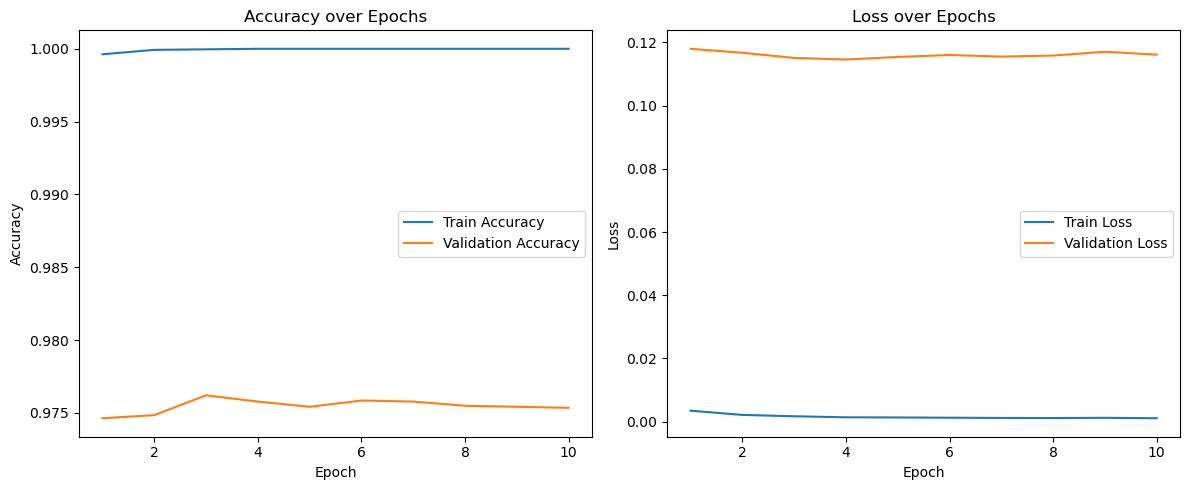

In [230]:
# Plot accuracy and loss curves
epochs_range = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
